In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

film = pd.read_sql('''SELECT f.rental_duration, f.rental_rate, f.length, f.replacement_cost, f.rating, p.amount, c.name, date_format(rental_date, '%%M') AS 'month'
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
JOIN sakila.film f
ON i.film_id = f.film_id
JOIN sakila.payment p
ON p.rental_id = r.rental_id
JOIN sakila.film_category fc
ON fc.film_id = f.film_id
JOIN sakila.category c
ON c.category_id = fc.category_id
WHERE CONVERT(rental_date, DATE) BETWEEN '2005-01-01' AND '2005-12-31';''', engine)
pd.set_option('display.max_columns', None)
film

,rental_duration,rental_rate,length,replacement_cost,rating,amount,name,month
0,6,0.99,113,20.99,PG,0.99,Action,August
1,6,0.99,113,20.99,PG,0.99,Action,August
2,6,0.99,113,20.99,PG,0.99,Action,June
3,6,0.99,113,20.99,PG,3.99,Action,July
4,6,0.99,113,20.99,PG,1.99,Action,July
...,...,...,...,...,...,...,...,...
15857,4,4.99,74,22.99,R,6.99,Travel,May
15858,4,4.99,74,22.99,R,6.99,Travel,June
15859,4,4.99,74,22.99,R,4.99,Travel,July
15860,4,4.99,74,22.99,R,9.99,Travel,July


In [3]:
film['rented_in_august'] = film['month'] == 'August'
film

,rental_duration,rental_rate,length,replacement_cost,rating,amount,name,month,rented_in_august
0,6,0.99,113,20.99,PG,0.99,Action,August,True
1,6,0.99,113,20.99,PG,0.99,Action,August,True
2,6,0.99,113,20.99,PG,0.99,Action,June,False
3,6,0.99,113,20.99,PG,3.99,Action,July,False
4,6,0.99,113,20.99,PG,1.99,Action,July,False
...,...,...,...,...,...,...,...,...,...
15857,4,4.99,74,22.99,R,6.99,Travel,May,False
15858,4,4.99,74,22.99,R,6.99,Travel,June,False
15859,4,4.99,74,22.99,R,4.99,Travel,July,False
15860,4,4.99,74,22.99,R,9.99,Travel,July,False


In [4]:
film['rented_in_august'].value_counts()

False    10176
True      5686
Name: rented_in_august, dtype: int64

In [5]:
film = film.drop('month', axis=1)

In [6]:
film.dtypes

rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
amount              float64
name                 object
rented_in_august       bool
dtype: object

In [7]:
film['length'] = film['length'].astype('float') # This will be treated as float

In [8]:
film.isna().sum()


rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
amount              0
name                0
rented_in_august    0
dtype: int64

In [9]:
film['rating'].value_counts(dropna=False)

PG-13    3543
NC-17    3249
PG       3178
R        3152
G        2740
Name: rating, dtype: int64

In [10]:
film['name'].value_counts(dropna=False)

Sports         1164
Animation      1145
Action         1095
Sci-Fi         1093
Family         1083
Drama          1053
Documentary    1044
Foreign        1022
Games           955
Children        939
Comedy          932
Classics        930
New             927
Horror          834
Travel          827
Music           819
Name: name, dtype: int64

In [11]:
film['rating'].value_counts().index

Index(['PG-13', 'NC-17', 'PG', 'R', 'G'], dtype='object')

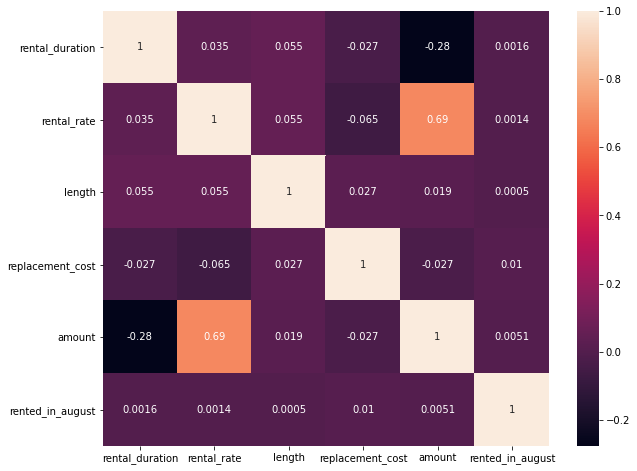

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix=film.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [13]:
y = film['rented_in_august']
X = film.drop('rented_in_august', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


X_train_num = X_train.select_dtypes('number')

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [15]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,rental_duration,rental_rate,length,replacement_cost,amount
0,0.75,0.5,0.719424,0.80,0.181818
1,1.00,0.0,0.388489,0.90,0.000000
2,0.25,1.0,0.194245,0.15,0.363636
3,1.00,1.0,0.956835,1.00,0.454545
4,0.50,1.0,0.035971,0.20,0.363636


In [16]:
X_train_categorical = X_train.select_dtypes('object')
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating', 'name'],
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
7563,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9589,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6140,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6911,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2596,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [18]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [19]:
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [20]:
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating', 'name'],
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# not needed if you treat each original column seperately with one_hot_encoder

X_test_cat.head()

<ipython-input-20-82f58141be85>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('name_Animation', 'name_Animation'),
 ('name_Children', 'name_Children'),
 ('name_Classics', 'name_Classics'),
 ('name_Comedy', 'name_Comedy'),
 ('name_Documentary', 'name_Documentary'),
 ('name_Drama', 'name_Drama'),
 ('name_Family', 'name_Family'),
 ('name_Foreign', 'name_Foreign'),
 ('name_Games', 'name_Games'),
 ('name_Horror', 'name_Horror'),
 ('name_Music', 'name_Music'),
 ('name_New', 'name_New'),
 ('name_Sci-Fi', 'name_Sci-Fi'),
 ('name_Sports', 'name_Sports'),
 ('name_Travel', 'name_Travel')]

,rating_NC-17,rating_PG,rating_PG-13,rating_R,name_Animation,name_Children,name_Classics,name_Comedy,name_Documentary,name_Drama,name_Family,name_Foreign,name_Games,name_Horror,name_Music,name_New,name_Sci-Fi,name_Sports,name_Travel
11948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12275,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
529,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15825,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9807,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [21]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [22]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.6448156318941065

In [23]:
print(y_test.value_counts())

False    2046
True     1127
Name: rented_in_august, dtype: int64


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[2046,    0],
       [1127,    0]], dtype=int64)

In [25]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.5578317050110305

In [26]:
confusion_matrix(y_test, predictions_clf)

array([[1548,  498],
       [ 905,  222]], dtype=int64)